In [620]:
import numpy as np
from random import shuffle
import abc
import matplotlib.pyplot as plt
from IPython.display import Math
from IPython.display import Latex
from sklearn import preprocessing
%matplotlib inline

## Activations

In [130]:
class Activation(metaclass=abc.ABCMeta):
    
    @abc.abstractmethod
    def function(self, x):
        """Implementation of the activation function."""
        
    @abc.abstractmethod
    def derivative(self, x):
        """Derivative of the activation function."""

### Sigmoid

In [174]:
Latex(r"""\begin{align}
f(x)=\frac{1}{1+e^{-x}}=\sigma(x)\quad
f'(x)=\sigma(x)\cdot(1-\sigma(x))=\frac{e^{-x}}{{(1+e^{-x}})^2}
\end{align}""")

<IPython.core.display.Latex object>

In [497]:
class Sigmoid(Activation):
    
    def function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivative(self, x):
        # alternative: self.function(x)*(1 - self.function(X))
        return np.exp(-x)/(1+np.exp(-x))**2

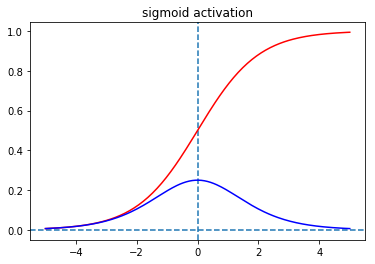

In [622]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("sigmoid activation")
plt.plot(x,Sigmoid().function(x), color="red")
plt.plot(x,Sigmoid().derivative(x), color="blue")

### ReLU

In [180]:
Latex(r"""\begin{align}
f(x)=\begin{cases}
  x, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}\quad
f'(x)=\begin{cases}
  1, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}
\end{align}""")

<IPython.core.display.Latex object>

In [181]:
class Relu(Activation):
    
    def function(self, x):
        return x * (x > 0)

    def derivative(self, x):
        return np.array(self.function(x) != 0, dtype="int")

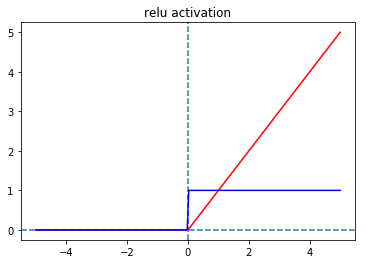

In [623]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("relu activation")
plt.plot(x,Relu().function(x), color="red")
plt.plot(x,Relu().derivative(x), color="blue")

### Hyperbolic Tangent

In [183]:
Latex(r"""\begin{align}
f(x)=\frac{e^{2x}-1}{e^{2x}+1}
\quad
f'(x)=\frac{4}{{e^{2x}+2+e^{-2x}}}
\end{align}""")

<IPython.core.display.Latex object>

In [184]:
class Tanh(Activation):
    
    def function(self, x):
        return (np.exp(2*x) - 1)/(np.exp(2*x) + 1)

    def derivative(self, x):
        # hyperbolic secant to the power of 2
        return (4/(np.exp(2*x) + 2 + np.exp(-2*x)))

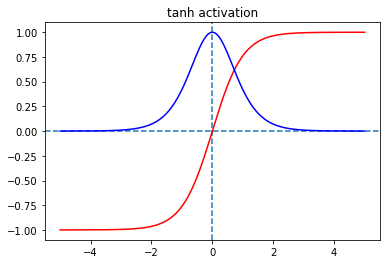

In [624]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("tanh activation")
plt.plot(x,Tanh().function(x), color="red")
plt.plot(x,Tanh().derivative(x), color="blue")

### Linear

In [143]:
class Linear(Activation):
    
    def function(self, x):
        return x

    def derivative(self, x):
        return 1

## Input Pipeline

In [641]:
class InputPipeLine:
    
    def __init__(self, data, batch_size):
        self.data = data
        self.size = len(self.data)
        self.batch_size = batch_size
        self.index = 0
    
    def next_batch(self):
        batch, eoe = self.step()
        return (np.array([element[0] for element in batch]),
                np.array([element[1] for element in batch]),
                eoe)
    
    def step(self):
        # flag value signaling the end of an epoch
        eoe = False
        if self.index + self.batch_size > self.size:
            self.index = 0
            # samples are shuffled after each epoch
            shuffle(self.data)
            eoe = True
        
        batch = self.data[self.index:self.index+self.batch_size]
        self.index += self.batch_size
        
        return batch, eoe

## Layers

In [555]:
class Layer:
    
    def __init__(self, activation, size):
        self.activation = activation
        self.value = None
        self.size = size
        
    def forward(self, x):
        self.value = self.activation.function(x)
        return self.value
        
    def backward(self):
        return self.activation.derivative(self.value)
    
    def isDropout(self):
        return False

#### Dropout

A reguralization layer that creates a mask over the neurons, and nullifies each output value with p probability. Dropout prevents overfitting as it combines an exponential amount of network architectures, rendering the ability of the individual neurons to develop co-dependency amongst each other during the training phase significantly lower. The network is forced to learn the data with a different subset of parameters, which means it has to learn a more generalized representation of the data to generate good results.

Let i be the i-th layer in a feed-forward neural network, x denote the vector output of the (i-1)-th layer, W and b are the weights and biases between the (i-1)-th and i-th layer, and m be a mask that has the same dimensions as x. The multiplication in the (2) is an element-wise product, while the one in (3) is standard matrix multiplication dot product.

In [312]:
Latex(r"""\begin{align}
m^{(i-1)} \sim Bernoulli(p) \\
\tilde{x}^{(i-1)} = x^{(i-1)}\cdot m^{(i-1)} \\
s^{(i)}=W^{(i-1)}\cdot \tilde{x}^{(i-1)}+b^{(i-1)} \\
y^{(i)}=f(s^{(i)})
\end{align}""")

<IPython.core.display.Latex object>

By applying the dropout on a layer, we are using only n*p (n is the number of units in a layer) neurons, hence, the expected output is p times the output without dropout. During testing phase or inference, we want to use the full neural network, so we have to scale down the output values in that layer. An alternative way of handling this issue is scaling up the output of the neurons during training phase, by dividing with p, so we don't have to deal with scaling during testing phase.

In [556]:
class Dropout(Layer):
    
    def __init__(self, layer, probability):
        super().__init__(layer.activation, layer.size)
        self.probability = probability
        # bernoulli distribution as the probabilty of retaining the neuron
        self.mask = np.random.binomial(1, self.probability, size=self.size)
    
    def forward(self, x):
        # using the "alternative" method described above
        return np.multiply(Layer.forward(self, x), self.mask)/self.probability
        
    def backward(self):
        return np.multiply(Layer.backward(self), self.mask)
    
    def isDropout(self):
        return True
    
    def recreate_mask(self, probability):
        self.probability = probability
        self.mask = np.random.binomial(1, self.probability, size=self.size)

#### Batch normalization

In [235]:
class BatchNorm(Layer):
    pass

## Optimizers

In [ ]:
def sgd_momentum():
    pass

def rmsprop():
    pass

def adagrad():
    pass

def adadelta():
    pass

def adam():
    pass

## Perceptron

In [714]:
class Mlp:
    
    def __init__(self, layers):
        self.layers = layers
        
        self.weight_matrices, self.biases = self.init_weights()
        
        # arrays to store the weight deltas for momentum
        self.dws = [0]*len(self.weight_matrices)
        self.dbs = [0]*len(self.weight_matrices)
        
        self.lrate = None
        self.momentum = None
        self.batch_size = None
        
    def init_weights(self):
        weights = []
        biases = []
        for index in range(len(self.layers)-1):
            weights.append(np.random.rand(self.layers[index].size, self.layers[index + 1].size))
            biases.append(np.random.rand(1, self.layers[index + 1].size))

        return weights, biases
            
    def train(self, input_pipe, lrate=0.01, momentum=0.9, epochs=1000):
        self.lrate = lrate
        self.momentum = momentum
        
        for epoch in range(epochs):
            while True:
                x, y, eoe = input_pipe.next_batch()
                self.forward_prop(x)
                error = self.back_prop(y)
                if eoe:
                    break
                
            if epoch % 20 == 0:
                print(">>> [Epoch: {0}\t] [Train Error: {1}\t]".format(epoch, error))
            
    def predict(self, x):
        self.layers[0].forward(x)
        
        for index in range(len(self.weight_matrices)):
            layer = self.layers[index+1]
            # removing dropout mask
            if layer.isDropout():
                p = layer.probability
                layer.recreate_mask(1)
            layer.forward(np.dot(self.layers[index].value, 
                            self.weight_matrices[index]) + self.biases[index])
            # replacing the mask
            if layer.isDropout():
                layer.recreate_mask(p)
        
        return self.layers[-1].value
                
    def forward_prop(self, x):
        self.batch_size = x.shape[0]
        self.layers[0].forward(x)
        
        for index in range(len(self.weight_matrices)):
            self.layers[index+1].forward(np.dot(self.layers[index].value, 
                            self.weight_matrices[index]) + self.biases[index])
        
    def back_prop(self, y):
        deltas = []
        
        error = -(y - self.layers[-1].value)
        deltas.append(np.multiply(self.layers[-1].backward(), 2*error))
        
        for index in range(len(self.weight_matrices)-1, 0,-1):
            deltas.insert(0, np.multiply(np.dot(deltas[0],
                                             self.weight_matrices[index].T), 
                                      self.layers[index].backward()))
        
        self.adjust_weights(deltas)
        
        for layer in self.layers:
            if layer.isDropout():
                layer.recreate_mask(layer.probability)
        
        return (error**2).sum()/layers[-1].size/self.batch_size
        
    def adjust_weights(self, deltas):
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = (-self.lrate*np.dot(self.layers[index].value.T, delta) + self.momentum*self.dws[index])/self.batch_size
            self.dws[index] = dw
            
            db = np.sum(-self.lrate*delta + self.momentum*self.dbs[index], axis=0)/self.batch_size
            self.dbs[index] = db
            
            self.weight_matrices[index] += dw
            self.biases[index] += db
            

>>> [Epoch: 0	] [Train Error: 0.3432938347559366	]
>>> [Epoch: 20	] [Train Error: 0.342308188617816	]
>>> [Epoch: 40	] [Train Error: 0.30259113853327624	]
>>> [Epoch: 60	] [Train Error: 0.23968719671303193	]
>>> [Epoch: 80	] [Train Error: 0.1759141828340009	]
>>> [Epoch: 100	] [Train Error: 0.12391013242522456	]
>>> [Epoch: 120	] [Train Error: 0.1018600069503786	]
>>> [Epoch: 140	] [Train Error: 0.15016302013833327	]
>>> [Epoch: 160	] [Train Error: 0.08759354162108503	]
>>> [Epoch: 180	] [Train Error: 0.0952783793254908	]
>>> [Epoch: 200	] [Train Error: 0.07266738958869548	]
>>> [Epoch: 220	] [Train Error: 0.08221335725696818	]
>>> [Epoch: 240	] [Train Error: 0.07656731466411038	]
>>> [Epoch: 260	] [Train Error: 0.057603165567925364	]
>>> [Epoch: 280	] [Train Error: 0.06366764895199974	]
>>> [Epoch: 300	] [Train Error: 0.0513854719711331	]
>>> [Epoch: 320	] [Train Error: 0.04789136301010891	]
>>> [Epoch: 340	] [Train Error: 0.031516976515530586	]
>>> [Epoch: 360	] [Train Error: 0.05139

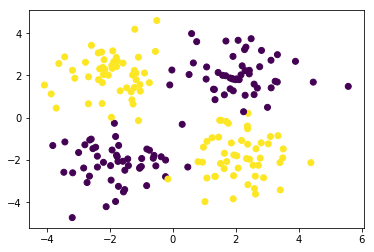

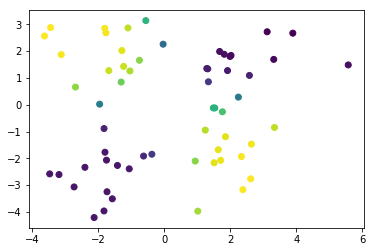

In [719]:
np.random.seed(1)

layers = []
layers.append(Layer(Linear(), size=2))
layers.append(Dropout(Layer(Relu(), size=20), probability=0.5))
layers.append(Layer(Sigmoid(), size=1))

mlp_object = Mlp(layers)

nb_samples=200
samples = []
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples.append([[-2+noise[0],-2+noise[1]], [0]])
    samples.append([[2+noise[2],-2+noise[3]],[1]])
    samples.append([[-2+noise[4],2+noise[5]],[1]])
    samples.append([[2+noise[6],2+noise[7]], [0]])

fig1=plt.figure()
plt.scatter([element[0][0] for element in samples],
            [element[0][1] for element in samples],
            c=[element[1] for element in samples])

pipe = InputPipeLine(samples[:int(len(samples)*0.7)], batch_size=32)
mlp_object.train(pipe)

fig1=plt.figure()
plt.scatter([element[0][0] for element in samples[int(len(samples)*0.7):]],
            [element[0][1] for element in samples[int(len(samples)*0.7):]],
            c=[element for element in mlp_object.predict([[element[0][0], element[0][1]] 
                                                          for element in samples[int(len(samples)*0.7):]])])
               